In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.io import arff
import os
import scipy.stats as stats
from scipy.stats import lognorm
from scipy.stats import norm

SEED = 21415

In [8]:
def process_dataset(dataset_filepath: str, pred_col_name: str):
    # Obtener la extension del archivo
    _, file_extension = os.path.splitext(dataset_filepath)

    # Cargar el dataset según la extensión
    if file_extension == '.arff':
        data = arff.loadarff(dataset_filepath)
        df = pd.DataFrame(data[0])

    elif file_extension == '.csv':
        df = pd.read_csv(dataset_filepath)

    else:
        raise ValueError("Formato no soportado, `dataset_filepath` debe tener una de las siguientes extensiones: .csv, .arff")

    # Separar el dataset en Train y Validation
    train_df, validation_df = train_test_split(df, test_size=0.2, random_state=SEED)
    y_train, y_valid = train_df[pred_col_name], validation_df[pred_col_name]
    X_train, X_valid = train_df.drop(pred_col_name, axis=1), validation_df.drop(pred_col_name, axis=1)

    # Aplicar get_dummies para variables categóricas
    X_train = pd.get_dummies(X_train)
    X_valid = pd.get_dummies(X_valid)
    X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0) 

    # Crear y entrenar el modelo de Random Forest
    rf_model = RandomForestRegressor(random_state=SEED)
    rf_model.fit(X_train, y_train)

    # Obtener las predicciones de cada árbol en el bosque
    tree_predictions = []
    for tree in rf_model.estimators_:
        tree_pred = tree.predict(X_valid)
        tree_predictions.append(tree_pred)

    # Evaluar el modelo
    predictions = rf_model.predict(X_valid)
    mse = mean_squared_error(y_valid, predictions)

    return df, mse, predictions, tree_predictions

In [16]:
def lognormal_fit_check(tree_predictions, shift=1e-6):
    ks_results = []
    for predictions in tree_predictions:
        # Apply a small shift to make all values positive
        shifted_predictions = predictions + shift

        # Estimate parameters of the lognormal distribution
        shape, loc, scale = stats.lognorm.fit(shifted_predictions, floc=0)
        
        # Perform the Kolmogorov-Smirnov test
        ks_stat, p_value = stats.kstest(shifted_predictions, 'lognorm', args=(shape, loc, scale))
        ks_results.append((ks_stat, p_value, shape, loc, scale))
    
    return ks_results

def plot_all_log_normal_fits(tree_predictions, dataset_name, save=False):
    plt.figure(figsize=(10, 6))
    
    # Use a colormap to get different colors for each instance
    cmap = get_cmap('tab10')

    for i, predictions in enumerate(tree_predictions):
        predictions = np.array(predictions)
        
        # Get a color from the colormap
        color = cmap(i % cmap.N)
        
        # Plot the KDE of the predictions
        sns.kdeplot(predictions, color=color, lw=1.5, alpha=0.5)  # Less prominent

        # Fit the log-normal distribution only for positive values
        predictions = predictions[predictions > 0]
        shape, loc, scale = lognorm.fit(predictions, floc=0)
        x = np.linspace(min(predictions), max(predictions), 1000)
        pdf_fitted = lognorm.pdf(x, shape, loc, scale)

        # Plot the fitted log-normal distribution with a dashed line
        plt.plot(x, pdf_fitted, color=color, lw=1.5, linestyle='--', alpha=0.7)

    # Make the original log-normal more distinctive
    original_predictions = np.concatenate(tree_predictions)  # Aggregate all predictions
    original_predictions = original_predictions[original_predictions > 0]
    shape, loc, scale = lognorm.fit(original_predictions, floc=0)
    x = np.linspace(min(original_predictions), max(original_predictions), 1000)
    original_pdf_fitted = lognorm.pdf(x, shape, loc, scale)

    plt.plot(x, original_pdf_fitted, color='red', lw=3, linestyle='-', alpha=1.0, label='Original Log-Normal')

    plt.title(f'Distribuciones de las predicciones vs Distribuciones Log-Normales Fitteadas')
    
    if save:
        plt.savefig(f'graficos/{dataset_name}_all_distributions_log.png', format='png', dpi=300, bbox_inches='tight')

    plt.show()


def print_ks_res(tree_predictions):
    ks_results = lognormal_fit_check(tree_predictions)
    avg_ks, avg_pvalue = 0, 0

    for i, (ks_stat, p_value, shape, loc, scale) in enumerate(ks_results):
        avg_ks += ks_stat
        avg_pvalue += p_value

    print(f"AVG KS: {avg_ks / len(ks_results)} | AVG p-value: {avg_pvalue / len(ks_results)}")

In [10]:
dataset_filepath = 'titanic_fare_test.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Fare'  # Columna a predecir
dataset_titanic, mse_titanic, predictions_titanic, tree_predictions_titanic = process_dataset(dataset_filepath, pred_col_name)

d:\Programas\miniconda3\envs\ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Programas\miniconda3\envs\ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Programas\miniconda3\envs\ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Programas\miniconda3\envs\ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Programas\miniconda3\envs\ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Programas\miniconda3\envs\ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has featu

C:\Users\feder\AppData\Local\Temp\ipykernel_9988\3083101437.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


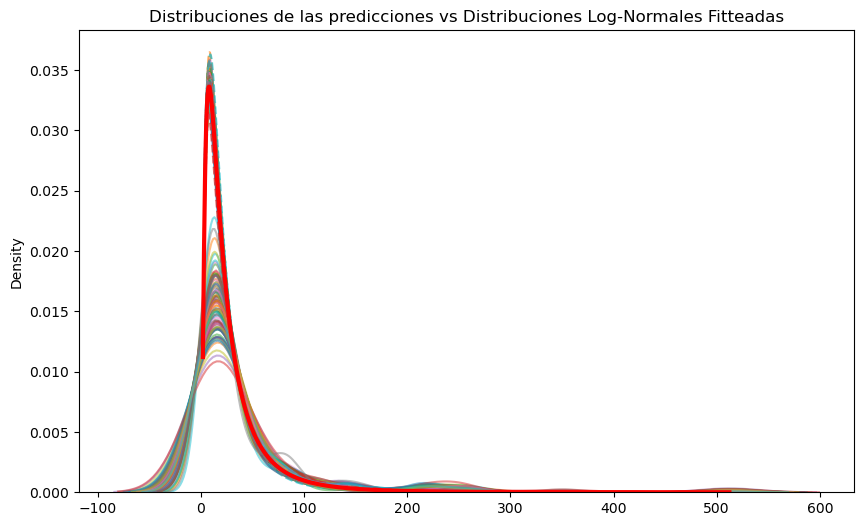

In [17]:
plot_all_log_normal_fits(tree_predictions_titanic, 'titanic')

In [18]:
print(tree_predictions_titanic)

[array([ 27.7208    ,  10.83333333,  15.82018644,  27.75      ,
        16.        ,  15.82018644,   7.25      ,   7.76458333,
         9.225     ,   7.32022857,   7.32022857,  25.4667    ,
        13.8583    ,  26.55      ,   7.78333333,  21.66666667,
        26.2875    ,  15.82018644,   7.925     ,  15.82018644,
        27.75      ,  39.6       , 113.275     ,  40.7562375 ,
        14.5       ,  13.        ,  15.2458    ,   8.96323529,
        39.        ,  26.25      ,  29.125     ,  15.82018644,
         7.66832   ,  15.2458    ,   7.96416   ,   8.30118929,
        26.        ,   8.0301    ,  78.2667    ,  27.7208    ,
        18.7875    ,  13.4167    ,  14.4542    ,   7.8792    ,
         7.2271    ,  15.82018644,  56.1028    ,  10.5       ,
        52.5542    ,   7.75      ,  14.4542    ,  30.6958    ,
         8.30118929,  13.        ,  31.6833    ,   8.2395875 ,
       512.3292    ,  16.1       ,   8.96323529,  12.75      ,
         8.6014    ,  10.5       ,   7.32022857,  28.7